# 109511276 練鈞揚
# HW 2 Part I : Classification
### Env : Anaconda Python 3.11

In [1]:
# rich print pretty
from rich import print as print , inspect


In [2]:
# from rich.traceback import install
# install(show_locals=True)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from dataclasses import dataclass
from collections import Counter
import seaborn as sns
from pprint import pformat
from scipy.stats import multivariate_normal
import scipy
from copy import deepcopy


In [4]:
data_df = pd.read_excel("HW2.xlsx")
data_df


,Unnamed: 0,x1,x2,class
0,0,18.73341,64.74255,1
1,1,3.99410,90.31358,1
2,2,23.39904,87.20672,1
3,3,24.83011,65.38512,1
4,4,13.73641,53.82633,1
...,...,...,...,...
995,995,54.10317,17.12986,4
996,996,93.22444,11.30329,4
997,997,86.16369,28.73599,4
998,998,79.43405,22.69025,4


### Type number

In [5]:
data_class_list = data_df['class']

count_dict = Counter(data_class_list)

set_of_class_type = set(data_class_list)
print(set_of_class_type)
print(count_dict)


TYPE_NUMBER = len(set_of_class_type)
COLOR_DICT = {1: "blue", 2: "green", 3: "red", 4: "black"}

{1, 2, 3, 4}

Counter({1: 400, 2: 250, 3: 200, 4: 150})

### build class

In [6]:
class BasketballPlayersDataControl:
    def __init__(self,data_load):  
        self.data_class_list = np.array([(row['x1'] , row['x2'] , int(row['class'])) for _, row in data_load])
        self.data_group_counter = Counter(list(map(int,self.data_class_list[:,2])))
        
        self.data_vec = np.array([self.data_class_list[:,0], self.data_class_list[:,1]]).T
        
        self.data_split_by_group = {
            class_number:
            np.array([(x1, x2) for x1 , x2 , c in self.data_class_list if c == class_number])
            for class_number in self.data_class_list[:,2]
        }
        
        self.t_format_dict = self.get_1_of_k_function()
        self.t_data_pool = np.array(list(map(self.t_format_dict.get , self.data_class_list[:,2])))
    
    def get_1_of_k_function(self):
        res = np.zeros(max(self.data_group_counter.keys()))
        def t_format(arr , number):
            arr[number - 1] = 1
            return arr
        return {
            key:
            t_format(deepcopy(res) , key)
            for key in self.data_group_counter.keys()
        }
    
    def get_data_vec(self):
        return self.data_vec
    
    def get_t_format_dict(self):
        return self.t_format_dict
    
    def get_data_t_format_data_pool(self):
        return self.t_data_pool
    
    def get_data(self):
        return self.data_class_list
    
    def __len__(self):
        return len(self.data_class_list)

    def get_data_group_counter(self):
        return self.data_group_counter
    
    def get_data_split_by_group(self):
        return self.data_split_by_group
    
    
    def plot_data(self):
        data_x1, data_x2 = self.data_class_list[:,0] , self.data_class_list[:,1] 
        data_color = list(map(COLOR_DICT.get, self.data_class_list[:,2]))
        
        plt.clf()
        plt.scatter(data_x1, data_x2, c=data_color)
        plt.title("Data")

        plt.xlabel("athleticism")
        plt.ylabel("skill")

        plt.show() 
        

In [7]:
bpd_data_list = BasketballPlayersDataControl(data_load=data_df.iterrows())

In [8]:
bpd_data_list.get_data_group_counter()

Counter({1: 400, 2: 250, 3: 200, 4: 150})

In [9]:
print({k :len(v) for k , v in bpd_data_list.data_split_by_group.items()})

{1.0: 400, 2.0: 250, 3.0: 200, 4.0: 150}

In [10]:
print(bpd_data_list.get_t_format_dict())

{1: array([1., 0., 0., 0.]), 2: array([0., 1., 0., 0.]), 3: array([0., 0., 1., 0.]), 4: array([0., 0., 0., 1.])}

In [11]:
print(bpd_data_list.get_data_t_format_data_pool())

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]

In [12]:
print(bpd_data_list.get_data())

[[18.73341 64.74255  1.     ]
 [ 3.9941  90.31358  1.     ]
 [23.39904 87.20672  1.     ]
 ...
 [86.16369 28.73599  4.     ]
 [79.43405 22.69025  4.     ]
 [56.86633 17.46885  4.     ]]

In [13]:
print(bpd_data_list.get_data_vec())

[[18.73341 64.74255]
 [ 3.9941  90.31358]
 [23.39904 87.20672]
 ...
 [86.16369 28.73599]
 [79.43405 22.69025]
 [56.86633 17.46885]]

### plot data 

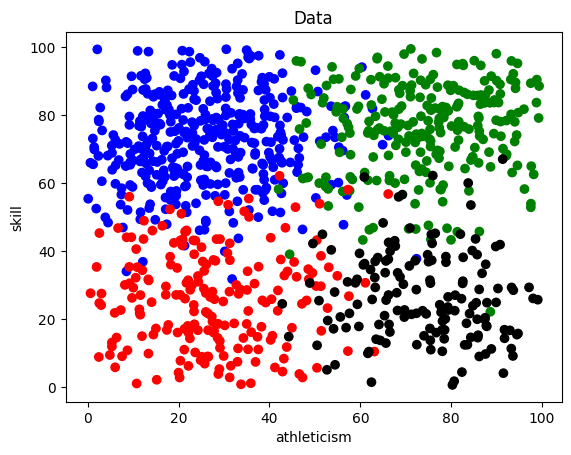

In [14]:
bpd_data_list.plot_data()

## Model 1 : Generative Model

#### Ref link
- https://wenwu53.com/classification-probabilistic-generative-model/
##### gaussian distribution
- http://cs229.stanford.edu/section/gaussians.pdf
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

In [15]:
class GenerativeModel:
    def __init__(self) -> None:
        # using the fit to find out 
        self.data_group_counter = None
        self.data_split_by_group = None
        self.group_number_list = None
        
        # for model 
        self.mean_dict = None 
        self.cov_matrix = None 
        self.pi_dict = None
        self.using_data = None

    def __init__(self ,bpd_data_control:BasketballPlayersDataControl) -> None:
        self.data_group_counter = bpd_data_control.get_data_group_counter()
        self.data_split_by_group = bpd_data_control.get_data_split_by_group()
        self.group_number_list = list(self.data_group_counter.keys())
    
    @classmethod
    def load_data(cls , bpd_data_control :BasketballPlayersDataControl):
        return cls(bpd_data_control)
    
    def find_mean(self):
        return {
            class_number:
            np.mean(line, axis=0)
            for class_number, line in self.data_split_by_group.items()
        }

    def group_pi_coef(self):
        N = sum(self.data_group_counter.values())
        
        N_class_list = list(np.array(list(self.data_group_counter.values())) / N)
        
        return dict(zip(self.group_number_list, N_class_list))

    def covariance_matrix(self):

        def build_group_matrix(group_of_matrix , group_mean, coef):
            matrix_term_list = [item_vec - group_mean
                                for item_vec in group_of_matrix]

            matrix_term_list = [
                item.reshape(-1, 1) @ [item] 
                for item in matrix_term_list
            ]
            
            sz = len(matrix_term_list)

            return coef * (1.0/sz) * np.sum(matrix_term_list ,axis=0)

        result_dict = {
            i:
            build_group_matrix(group_of_matrix=self.data_split_by_group[i],
                               group_mean=self.mean_dict[i],
                               coef=self.pi_dict[i])
            
            for i in self.group_number_list
        }

        return np.sum(list(result_dict.values()), axis=0)

    def fit(self):
        self.mean_dict = self.find_mean()
        
        self.pi_dict = self.group_pi_coef()
        
        self.cov_matrix = self.covariance_matrix()
        
        self.using_data = [(self.pi_dict[group] , self.mean_dict[group]) for group in self.group_number_list]
    
    def join_pdf(self, x):
        
        return np.array([pi_item * multivariate_normal.pdf(x=x , mean=mean_item , cov=self.cov_matrix) 

                         for pi_item, mean_item in self.using_data])
    
    def prediction(self , x):
        
        result_vector = (join_pdf_res := self.join_pdf(x=x)) / np.sum(join_pdf_res)
        
        return self.group_number_list[np.argmax(result_vector)]
    
    
    def __str__(self) -> str:
        return f"""
{self.__class__.__name__}
    
pi_dict : 
{pformat(self.pi_dict)}
    
mean_dict: 
{pformat(self.mean_dict)}, 
    
covariance matrix: 
{self.cov_matrix}"""


In [16]:
## testing

gm_model = GenerativeModel.load_data(bpd_data_list)

gm_model.fit()
print(gm_model)

GenerativeModel
    
pi_dict : 
{1: 0.4, 2: 0.25, 3: 0.2, 4: 0.15}
    
mean_dict: 
{1.0: array([25.90238108, 72.8619133 ]),
 2.0: array([74.157746  , 75.88818556]),
 3.0: array([27.40313325, 26.22084015]),
 4.0: array([74.15287553, 26.6224472 ])}, 
    
covariance matrix: 
[[186.38980095   7.86502509]
 [  7.86502509 182.43369113]]

(2, 2)

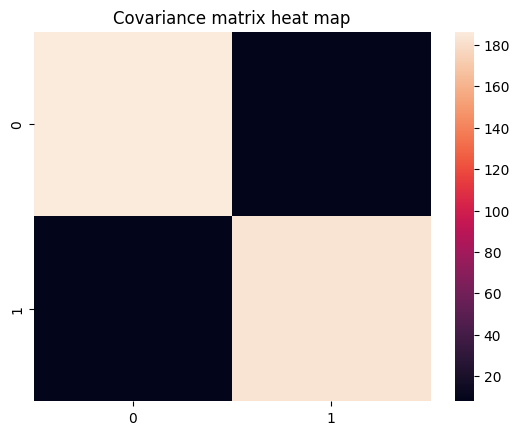

In [17]:
cov_matrix = gm_model.cov_matrix
print(cov_matrix.shape)
plt.clf()
plt.title("Covariance matrix heat map")
sns.heatmap(cov_matrix)

plt.show()

## Predict

In [18]:
def get_testing_point_in_space(x_space , y_space , step):
    test_x , test_y = np.linspace(0 , x_space + 1 , step), np.linspace(0 , y_space + 1 , step)
    test_xx , test_yy = np.meshgrid(test_x , test_y)
    return np.column_stack((test_xx.ravel(), test_yy.ravel()))

In [19]:
points = get_testing_point_in_space(100,100,100)

test_output_array = np.array([(point[0], point[1], gm_model.prediction(x=point)) for point in points])


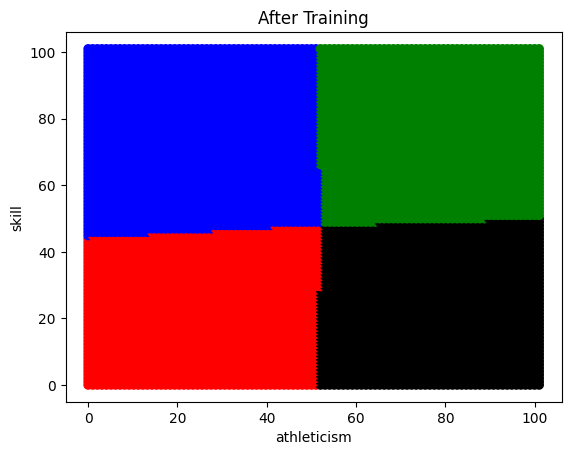

In [20]:
test_x1_list ,test_x2_list , test_group_list  = test_output_array[:,0] , test_output_array[:,1] , list(map(COLOR_DICT.get, test_output_array[:,2]))

plt.clf()

plt.scatter(test_x1_list, test_x2_list, c=test_group_list)
plt.title("After Training")

plt.xlabel("athleticism")
plt.ylabel("skill")

plt.show()

## Model 2 : Discriminative Model

### Ref
- https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/basis-functions.pdf
- https://www.youtube.com/watch?v=wq1K8F-S0AI

In [21]:
# import autograd.numpy as np
# from autograd import grad , hessian

In [62]:
class DiscriminativeModel:
   
    
    def __init__(self , M= 5) -> None:
        # about M 
        self.M = M
        
        # about data
        self.data_group_counter = None
        # self.data_split_by_group = None
        self.group_number_list = None
        
        # self.k_group_list: list = None
        self.weight_vec: np.ndarray = None
        self.t_format_base = None
        
        # data_pool
        self.t_data_pool = None
        self.y_data_pool = None
        self.phi_matrix = None
        self.mean_vector = None
        # using for the model  
        self.eye_matrix = None
    
    def __init__(self, bpd_data:BasketballPlayersDataControl):
        
        self.data_group_counter = bpd_data.get_data_group_counter()
        # self.data_split_by_group = bpd_data.get_data_split_by_group()
        self.group_number_list = list(self.data_group_counter.keys())
        
        
        
        self.mean_vector = np.array([
            np.mean(data_line, axis=0)
            for _ , data_line in bpd_data.get_data_split_by_group().items()
        ])
        
        self.basis_func_pdf_list = self.pdf_builder(bpd_data.get_data_vec())
        
        self.phi_matrix = np.array([
            self.basis_function_vector_builder(x=line_vec) 
            for line_vec in bpd_data.get_data_vec()
        ])
        
        # print(self.phi_matrix.shape)
        
        self.K = np.max(self.group_number_list)
        self.M = self.phi_matrix.shape[1]
        
        # using for the model  
        self.eye_matrix = np.eye(len(self.group_number_list))
        
        # init weight
        self.weight_vec = np.random.random(self.M*self.K).reshape(self.K , self.M)
        
        # t format base
        self.t_format_base = np.zeros(int(np.max(self.group_number_list)))
        
        # data_pool
        self.t_data_pool = bpd_data.get_data_t_format_data_pool()
        
        self.data_len = len(self.t_data_pool)
    
    
        
         
        # after predict
        self.y_data_pool = None
        
################################################################################################
    @classmethod
    def load_data(cls, bpd_data):
        return cls(bpd_data)

    def group_weight(self):
        return dict(zip(self.group_number_list, self.weight_vec))
    
################################################################################################
    def pdf_builder(self , data):
        cov = np.cov(data.T)
        
        print(cov)
        
        return [multivariate_normal(mean=mean_vector, cov=cov) 
                for mean_vector in self.mean_vector]
    
    
    @staticmethod
    def logic_sigmoid(a):
        return 1 /(1 + np.exp(-a))
    
    def basis_function_vector_builder(self, x):
        dis_vec = np.exp(np.array([
            pdf_function.pdf(x)
            for pdf_function in self.basis_func_pdf_list
        ]))
        
        dis_vec = dis_vec / np.sum(dis_vec)
    
        mean_dis = np.array([
            np.linalg.norm(x - mean_vector)
            for mean_vector in self.mean_vector 
        ])
        
        mean_dis = mean_dis / np.sum(mean_dis)
        
        manhattan_vec = np.array([
            np.sum(np.abs(x - mean_vector))
            for mean_vector in self.mean_vector 
        ])
        
        manhattan_vec = manhattan_vec / np.sum(manhattan_vec)
                
        return np.concatenate([dis_vec , mean_dis , manhattan_vec], axis=0)
    
    
################################################################################################
    @staticmethod
    def softmax(ak_list):
        return (ak_exp := np.exp(ak_list - np.max(ak_list))) / np.sum(ak_exp, axis=0)
    
    # output a vector # k x 1 vector
    @staticmethod
    def ak_mapping_function(weight_list, basis_function_vec):
        return np.array([
            weight @ basis_function_vec
            for weight in weight_list
        ])
    
    # output a vector # k x 1 vector # with normalization
    @staticmethod
    def y_predict_with_softmax(weight_list, basis_function_vec):
        dm = DiscriminativeModel
        
        return dm.softmax(ak_list=dm.ak_mapping_function(weight_list, basis_function_vec))
    
################################################################################################
    @staticmethod
    def cross_entropy_error_function(true_output, prediction_output):
        return -np.sum(true_output * np.log(prediction_output))

    # is w_new  = w_old ....... thing 
    
    # output a 1D array [...]
    def gradient_E(self):
        yt_data_pool = self.y_data_pool - self.t_data_pool
        
        return np.array([
            # linear combination of vector
            yt_j_vec @ self.phi_matrix
            for yt_j_vec in yt_data_pool.T
            
        ]).flatten()
    
    # linear combination of matrix 
    def hessian_matrix_item(self, k, j):
        R_matrix = np.diag(self.y_data_pool[:,k] * (int(k==j) - self.y_data_pool[:,j]))
        
        return self.phi_matrix.T @ R_matrix @ self.phi_matrix
    
    def hessian_matrix_line(self, k):
        
        # R = lambda k , j : np.eye(self.data_len) * (self.y_data_pool[:,k] * (int(k==j) - self.y_data_pool[:,j]))
        
        # first to build a item matrix 
        hessian_matrix_line_res = np.array([
            # self.hessian_matrix_item(k=k,j=j)
            self.hessian_matrix_item(k,j)
            for j in range(self.K)
        ])
        
        # after np.concatenate((A, B), axis=1) # by column
        return np.concatenate(hessian_matrix_line_res, axis=1)
    
    def hessian_matrix(self):
        # first to build a line of matrix
        
        hessian_matrix_res = np.array([
            self.hessian_matrix_line(k=k)
            for k in range(self.K)
        ])
        
        # after np.concatenate((A, B), axis=0) # by row 
        return np.concatenate(hessian_matrix_res, axis=0)
    
################################################################################################
    
    def newton_raphson(self,threshold=0.1):
        losses = []
        all_weight_list = []# for save the different iterations weight
        
        W_vec = np.concatenate(self.weight_vec)
        # print(W_vec)
        
        while True:
            if len(losses) > 1 and (abs(losses[-2] - losses[-1]) <= threshold):
                break
            
            weight_list = np.split(W_vec, self.K)
            
            all_weight_list.append(deepcopy(W_vec))
            
            self.y_data_pool = np.array([
                
                self.y_predict_with_softmax(
                    weight_list=weight_list,
                    basis_function_vec=phi_line)
    
                for phi_line in self.phi_matrix
            ])

            loss_now = self.cross_entropy_error_function(true_output=self.t_data_pool,
                                                         prediction_output=self.y_data_pool)
            print(loss_now)
            
            losses.append(loss_now)
            
            del_E = self.gradient_E()
            H_matrix = self.hessian_matrix()
            
            # print(H_matrix.shape)
            
            W_vec -= np.linalg.pinv(H_matrix) @ del_E
            # W_vec -= self.inv(H_matrix) @ del_E
        
        # final to save the weight dict 
        self.weight_vec = np.split(W_vec,self.K)
        
        return losses, all_weight_list
    
    def fit(self, threshold=0.1):
        return self.newton_raphson(threshold=threshold)
    
    # result is a group number 
    def prediction(self , x):
        # weight_list
        
        x_basis_function_vector = self.basis_function_vector_builder(x=x)
        
        predict_result = self.y_predict_with_softmax(
            weight_list=self.weight_vec, 
            basis_function_vec=x_basis_function_vector)
        
        # print(predict_result.shape)
        
        return self.group_number_list[np.argmax(predict_result)]
    
    
    def prediction_with_different_weight(self,x, test_weight):
        x_basis_function_vector = self.basis_function_vector_builder(x=x)
        test_weight = np.split(test_weight, self.K)
        
        predict_result = self.y_predict_with_softmax(
            weight_list=test_weight, 
            basis_function_vec=x_basis_function_vector)
        
        return self.group_number_list[np.argmax(predict_result)] 
    


In [63]:
d_model = DiscriminativeModel.load_data(bpd_data=bpd_data_list)

print(d_model.weight_vec)

[[ 7.34715178e+02 -3.15140497e-01]
 [-3.15140497e-01  7.00730559e+02]]

[[0.90215721 0.76608661 0.55619832 0.04649224 0.04260528 0.90796467
  0.73135957 0.7832209  0.43271987 0.31844372 0.75600684 0.39175052]
 [0.97844422 0.45505712 0.79498311 0.94178776 0.97601589 0.4991428
  0.03455584 0.95431389 0.98900216 0.67452023 0.93766432 0.3551316 ]
 [0.30078859 0.96879416 0.611438   0.61219209 0.43277102 0.72842457
  0.4151087  0.54381062 0.0906924  0.93723706 0.49432891 0.79624955]
 [0.60475589 0.70063296 0.70583531 0.93675025 0.60526541 0.99108733
  0.62745236 0.26052221 0.92938514 0.51864161 0.15609423 0.45014228]]

In [64]:
test_it = d_model.phi_matrix

In [65]:
d_model.mean_vector

array([[25.90238108, 72.8619133 ],
       [74.157746  , 75.88818556],
       [27.40313325, 26.22084015],
       [74.15287553, 26.6224472 ]])

In [66]:
a = d_model.basis_function_vector_builder(np.array([1,2]))
a

array([0.24999484, 0.24999386, 0.25001653, 0.24999477, 0.25713508,
       0.35596385, 0.12266111, 0.26423996, 0.2447903 , 0.37587513,
       0.12940374, 0.24993084])

In [67]:
d_model.weight_vec

array([[0.90215721, 0.76608661, 0.55619832, 0.04649224, 0.04260528,
        0.90796467, 0.73135957, 0.7832209 , 0.43271987, 0.31844372,
        0.75600684, 0.39175052],
       [0.97844422, 0.45505712, 0.79498311, 0.94178776, 0.97601589,
        0.4991428 , 0.03455584, 0.95431389, 0.98900216, 0.67452023,
        0.93766432, 0.3551316 ],
       [0.30078859, 0.96879416, 0.611438  , 0.61219209, 0.43277102,
        0.72842457, 0.4151087 , 0.54381062, 0.0906924 , 0.93723706,
        0.49432891, 0.79624955],
       [0.60475589, 0.70063296, 0.70583531, 0.93675025, 0.60526541,
        0.99108733, 0.62745236, 0.26052221, 0.92938514, 0.51864161,
        0.15609423, 0.45014228]])

In [68]:
d_model.ak_mapping_function(d_model.weight_vec,a)

array([1.61992008, 2.18334878, 1.82595028, 1.94637612])

In [69]:
losses, weight_list_vec = d_model.fit(threshold=0.1)

1340.4052640364835

295.88528470271456

252.5784402733812

238.55023754770687

232.51542703534437

230.13307059611427

229.65683472617758

229.62254130549283

In [70]:
after_train_dict = dict(enumerate(zip(losses, weight_list_vec)))
print(after_train_dict)

{
    0: (
        1340.4052640364835,
        array([0.90215721, 0.76608661, 0.55619832, 0.04649224, 0.04260528,
       0.90796467, 0.73135957, 0.7832209 , 0.43271987, 0.31844372,
       0.75600684, 0.39175052, 0.97844422, 0.45505712, 0.79498311,
       0.94178776, 0.97601589, 0.4991428 , 0.03455584, 0.95431389,
       0.98900216, 0.67452023, 0.93766432, 0.3551316 , 0.30078859,
       0.96879416, 0.611438  , 0.61219209, 0.43277102, 0.72842457,
       0.4151087 , 0.54381062, 0.0906924 , 0.93723706, 0.49432891,
       0.79624955, 0.60475589, 0.70063296, 0.70583531, 0.93675025,
       0.60526541, 0.99108733, 0.62745236, 0.26052221, 0.92938514,
       0.51864161, 0.15609423, 0.45014228])
    ),
    1: (
        295.88528470271456,
        array([ 1.25398808e+05, -4.54775732e+04, -2.78914454e+04, -5.20272580e+04,
        8.18687296e+00, -2.30802307e+00,  1.52817724e+00, -4.47616441e+00,
       -9.07674555e+00,  8.99564754e+00,  8.84836666e+00, -8.89857310e+00,
       -3.29480947e+04,  5.27138639e+04, -6.27094597e+03, -1.34923885e+04,
       -7.82810656e-01,  2.74134747e+00, -1.60966515e+00,  2.56896318e+00,
       -3.88754787e+00,  3.00650272e+00,  7.20775225e+00, -6.24578585e+00,
       -7.26192396e+04, -1.22704660e+04,  7.60818187e+04,  8.80986159e+03,
        4.31961265e-01, -2.18727959e+00,  1.43470685e+00,  2.09868063e+00,
        1.13574436e+01, -1.27188199e+01, -1.67788415e+01,  1.98179795e+01,
       -1.98285450e+04,  5.03965602e+03, -4.19164053e+04,  5.67083912e+04,
       -4.86014549e+00,  4.40219796e+00,  1.32589453e+00,  1.36596782e+00,
        2.59798391e+00,  1.54093483e+00, -1.32269077e+00, -3.46059907e+00])
    ),
    2: (
        252.5784402733812,
        array([ 7.63210967e+04, -5.72295547e+04, -5.64359301e+04,  3.73471988e+04,
        7.74335650e+00, -5.66681914e+00, -7.42277664e+00,  9.74175371e+00,
       -1.73826732e+01,  1.02342248e+01,  1.19707254e+01, -6.87844593e+00,
       -2.59452050e+04,  3.65360120e+04,  3.71309031e+04, -4.77223969e+04,
       -5.00129589e+00, -1.13486500e-01,  9.91484122e+00, -8.65484675e-01,
        1.51779455e-01,  3.12525220e+00,  6.04018098e+00, -7.38845098e+00,
       -3.36376359e+04, -2.59141605e+03,  1.05151461e+05, -6.89196965e+04,
       -1.80575588e+00,  3.36762280e+00,  5.38776770e+00, -7.06237425e+00,
        8.46224968e+00, -6.25455104e+00, -8.93521722e+00,  9.02175844e+00,
       -1.67375818e+04,  2.32913516e+04, -8.58441090e+04,  7.92928084e+04,
        3.19060188e-01,  7.04175650e+00, -6.00718705e+00,  2.66317447e-01,
        8.69493404e+00, -7.28869309e+00, -1.00748000e+01,  8.43785806e+00])
    ),
    3: (
        238.55023754770687,
        array([-1.36726686e+04, -7.45840668e+04, -8.22785856e+04,  1.70549379e+05,
        3.03243304e+00, -9.59562127e+00, -1.97306865e+01,  2.90376501e+01,
       -2.38618076e+01,  5.32744638e+00,  1.27332514e+01, -3.40694544e+00,
       -2.43800920e+04, -2.91178548e+04,  1.23291282e+05, -6.97929160e+04,
       -8.99515174e+00, -5.67401418e+00,  2.33204190e+01, -4.41477564e+00,
        7.74774866e+00, -4.19713150e+00,  4.61021761e+00, -5.34535625e+00,
        6.39342589e+03,  5.34332314e+04,  8.85428939e+04, -1.48370183e+05,
       -1.49023464e+00,  1.60843936e+01,  7.25648456e+00, -1.70225944e+01,
        1.87541867e+00,  5.88735547e+00,  1.44159481e+00, -6.59052724e+00,
        3.16620167e+04,  5.02757461e+04, -1.29550336e+05,  4.76161512e+04,
        1.18227608e+01,  8.08358941e+00, -1.23287014e+01, -5.60639375e+00,
        1.45195561e+01, -1.08704587e+01, -1.69573812e+01,  1.31756545e+01])
    ),
    4: (
        232.51542703534437,
        array([-1.46372921e+05, -1.06740626e+05, -1.07920794e+05,  3.61039702e+05,
       -8.10038517e+00, -6.35440182e+00, -3.04408896e+01,  6.57147030e+01,
       -2.20833686e+01, -4.78771131e+00,  9.82805057e+00,  4.89993330e+00,
       -1.53960779e+04, -1.37775208e+05,  2.42963825e+05, -8.97769325e+04,
       -1.86509424e+01, -1.42883119e+01,  3.57959079e+01, -6.02898119e+00,
        2.00270367e+0

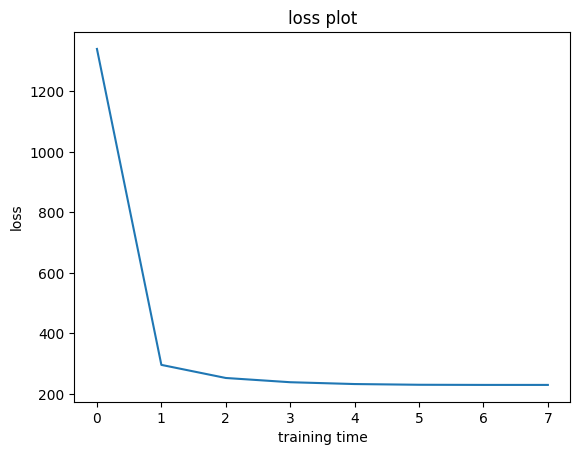

In [71]:
plt.clf()

pd.Series(losses).plot()
plt.title("loss plot")
plt.ylabel("loss")
plt.xlabel("training time")
plt.show()

In [72]:
points = get_testing_point_in_space(100,100,100)

# points

In [73]:
test_group_1 = bpd_data_list.data_split_by_group

In [74]:
for k , test_group in test_group_1.items():
    get = Counter([d_model.prediction(x=test_point) for test_point in test_group]).most_common()[0]
    print(f"pre-test {int(k)} : most comment {get}, acc = {get[1]/len(test_group) * 100} ")
    

pre-test 1 : most comment (1, 374), acc = 93.5

pre-test 2 : most comment (2, 223), acc = 89.2

pre-test 3 : most comment (3, 177), acc = 88.5

pre-test 4 : most comment (4, 135), acc = 90.0

In [75]:
test_output_array = np.array([(point[0], point[1], d_model.prediction(x=point)) for point in points])


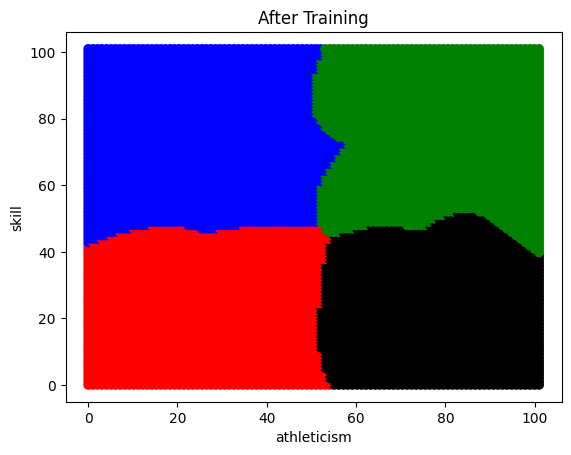

In [76]:
test_x1_list ,test_x2_list , test_group_list  = test_output_array[:,0] , test_output_array[:,1] , list(map(COLOR_DICT.get, test_output_array[:,2]))

plt.clf()

plt.scatter(test_x1_list, test_x2_list, c=test_group_list)
plt.title("After Training")

plt.xlabel("athleticism")
plt.ylabel("skill")

plt.show()

## Different weight 

In [77]:
from PIL import Image
import imageio
import os

file_name = []

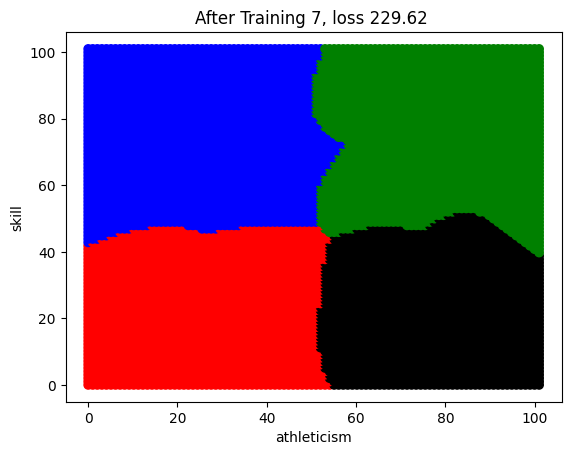

In [78]:
for index , (now_loss , weight_vec) in after_train_dict.items():
    
    test_output_array = np.array([
        (point[0], point[1], d_model.prediction_with_different_weight(x=point,test_weight=weight_vec)) 
        for point in points])


    test_x1_list ,test_x2_list , test_group_list  = test_output_array[:,0] , test_output_array[:,1] , list(map(COLOR_DICT.get, test_output_array[:,2]))

    plt.clf()

    plt.scatter(test_x1_list, test_x2_list, c=test_group_list)
    plt.title(f"After Training {index}, loss {now_loss:.2f} ")

    plt.xlabel("athleticism")
    plt.ylabel("skill")

    fig_filename = f"Part_I_figure_{index}.png"
    plt.savefig(fig_filename)
    file_name.append(fig_filename)
    
    
    # plt.show()

In [79]:
gif_filename = "PartI.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for fig_filename in file_name:
        image = Image.open(fig_filename)
        writer.append_data(np.array(image))
        image.close()


In [80]:
# delete the figure files
for fig_filename in file_name:
    os.remove(fig_filename)

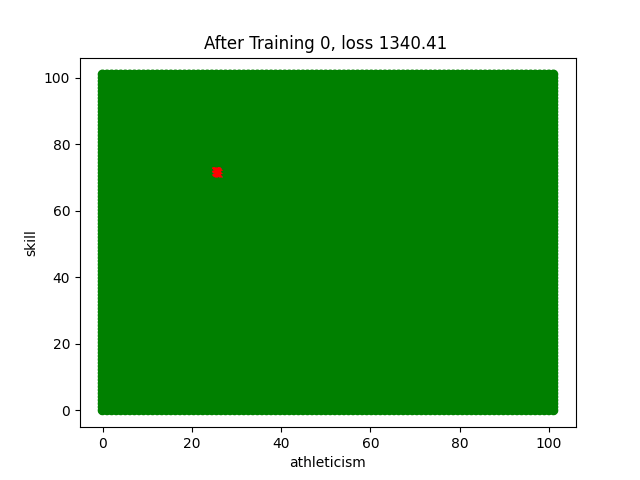

In [81]:
from IPython.display import Image
with open(gif_filename,'rb') as f:
    display(Image(data=f.read(), format='png'))